In [2]:
import matplotlib.pyplot as plt
import numpy as numpy
import pandas as pd


Text(0, 0.5, 'Frequentie')

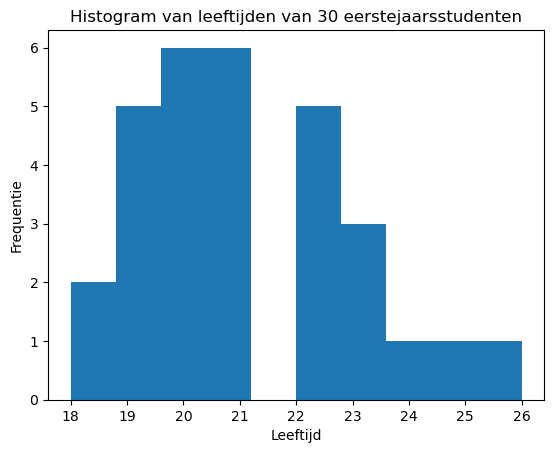

In [3]:

x = [18, 23, 23, 21, 20, 19, 22, 21, 20, 21, 20, 19, 23, 22, 18, 19, 22, 26, 21, 22, 24, 20, 19, 25, 20, 21, 19, 20, 22, 21]
plt.hist(x)
plt.title("Histogram van leeftijden van 30 eerstejaarsstudenten")
plt.xlabel("Leeftijd")
plt.ylabel("Frequentie")

In [4]:
df = pd.DataFrame()
df["Leeftijd"] = [18, 23, 23, 21, 20, 19, 22, 21, 20, 21, 20, 19, 23, 22, 18, 19, 22, 26, 21, 22, 24, 20, 19, 25, 20, 21, 19, 20, 22, 21]
df["Woonsituatie"] = list("zozoooozzzozzzozzoooozozozozzo")
df["Geslacht"] = list('vmvmvmmmmvmvmvvmvmmmmmmvmmmvvv')
df["Besteding"] = [510, 280, 440, 490, 330, 260, 420, 570, 530, 590, 460, 480, 550, 470, 380, 540, 390, 450, 270, 390, 540, 360, 290, 460, 310, 570, 280, 410, 510, 330]
df["Score"] = [72, 62, 49, 58, 86, 67, 95, 68, 72, 63, 52, 73, 92, 72, 45, 68, 46, 38, 83, 86, 47, 96, 72, 48, 81, 84, 51, 62, 78, 46]
df

,Leeftijd,Woonsituatie,Geslacht,Besteding,Score
0,18,z,v,510,72
1,23,o,m,280,62
2,23,z,v,440,49
3,21,o,m,490,58
4,20,o,v,330,86
5,19,o,m,260,67
6,22,o,m,420,95
7,21,z,m,570,68
8,20,z,m,530,72
9,21,z,v,590,63


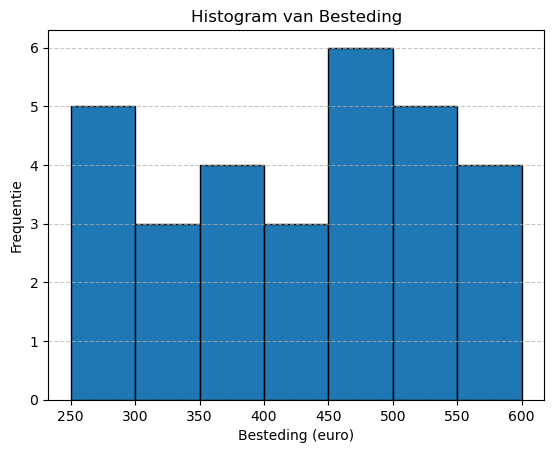

In [5]:
plt.hist(df["Besteding"], bins=range(250, df["Besteding"].max() + 50, 50), edgecolor='black')

# As-labels en titel
plt.xlabel("Besteding (euro)")
plt.ylabel("Frequentie")
plt.title("Histogram van Besteding")
plt.grid(axis='y', linestyle='--', alpha=0.7)

In [6]:

# Klassen maken: klassen van 10 breed, vanaf 30 tot 100
score_klassen = pd.cut(df["Score"], bins=range(30, 101, 10), right=False)

# Geslacht toevoegen
df["Score_klas"] = score_klassen

# Kruistabel maken
kruistabel = pd.crosstab(df["Score_klas"], df["Geslacht"])
print(kruistabel)

Geslacht    m  v
Score_klas      
[30, 40)    1  0
[40, 50)    1  5
[50, 60)    3  0
[60, 70)    4  2
[70, 80)    2  4
[80, 90)    4  1
[90, 100)   3  0


In [7]:
# Absoluut aantal (zoals eerder)
kruistabel_abs = pd.crosstab(df["Score_klas"], df["Geslacht"])

# Relatieve frequenties berekenen per kolom (geslacht)
kruistabel_rel = kruistabel_abs.div(kruistabel_abs.sum(axis=0), axis=1) * 100

# Afronden op 1 decimaal voor netheid
kruistabel_rel = kruistabel_rel.round(1)

print(kruistabel_rel)

Geslacht       m     v
Score_klas            
[30, 40)     5.6   0.0
[40, 50)     5.6  41.7
[50, 60)    16.7   0.0
[60, 70)    22.2  16.7
[70, 80)    11.1  33.3
[80, 90)    22.2   8.3
[90, 100)   16.7   0.0


In [8]:
# Kruistabel maken van geslacht vs woonsituatie
kruistabel_geslacht_woonsituatie = pd.crosstab(df["Geslacht"], df["Woonsituatie"])

# Voeg totals per rij en kolom toe
kruistabel_geslacht_woonsituatie["Totaal"] = kruistabel_geslacht_woonsituatie.sum(axis=1)
kruistabel_geslacht_woonsituatie.loc["Totaal"] = kruistabel_geslacht_woonsituatie.sum(axis=0)

# Functie om LaTeX-tabel te genereren
def generate_latex_table_geslacht_woonsituatie(kruistabel):
    latex_code = "\\begin{table}[h!]\n"
    latex_code += "    \\centering\n"
    latex_code += "    \\caption{Kruistabel van geslacht versus woonsituatie}\n"
    latex_code += "    \\begin{tabular}{lccccc}\n"
    latex_code += "        \\toprule\n"
    latex_code += "        \\textbf{Geslacht} & \\textbf{Zelfstandig} & \\textbf{Bij ouders} & \\textbf{Totaal} \\\\\n"
    latex_code += "        \\midrule\n"
    
    for index, row in kruistabel.iterrows():
        latex_code += f"        {index} & {row['z']} & {row['o']} & {row['Totaal']} \\\\\n"
    
    latex_code += "        \\midrule\n"
    latex_code += f"        Totaal & {kruistabel['z'].sum()} & {kruistabel['o'].sum()} & {kruistabel['Totaal'].sum()} \\\\\n"
    latex_code += "        \\bottomrule\n"
    latex_code += "    \\end{tabular}\n"
    latex_code += "\\end{table}"
    
    return latex_code

# Genereer LaTeX-code voor de kruistabel geslacht vs woonsituatie
latex_output_geslacht_woonsituatie = generate_latex_table_geslacht_woonsituatie(kruistabel_geslacht_woonsituatie)

# Print de LaTeX-code voor geslacht vs woonsituatie
print(latex_output_geslacht_woonsituatie)

\begin{table}[h!]
    \centering
    \caption{Kruistabel van geslacht versus woonsituatie}
    \begin{tabular}{lccccc}
        \toprule
        \textbf{Geslacht} & \textbf{Zelfstandig} & \textbf{Bij ouders} & \textbf{Totaal} \\
        \midrule
        m & 6 & 12 & 18 \\
        v & 9 & 3 & 12 \\
        Totaal & 15 & 15 & 30 \\
        \midrule
        Totaal & 30 & 30 & 60 \\
        \bottomrule
    \end{tabular}
\end{table}


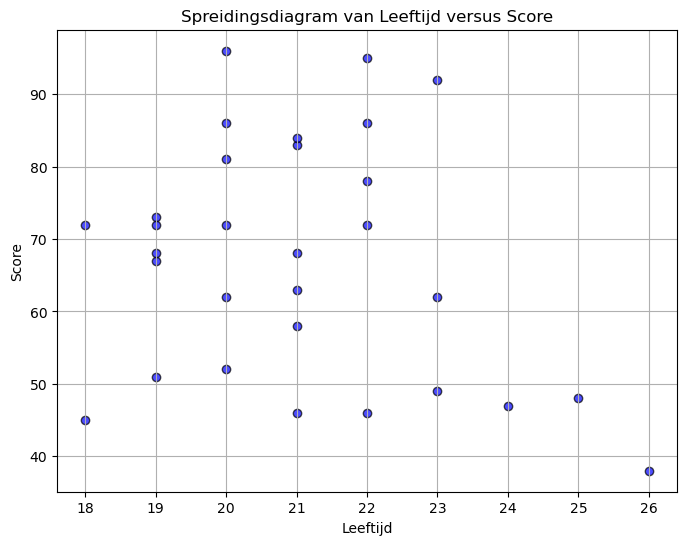

In [9]:
# Dataframe (uw voorbeeld)
df = pd.DataFrame({
    "Leeftijd": [18, 23, 23, 21, 20, 19, 22, 21, 20, 21, 20, 19, 23, 22, 18, 19, 22, 26, 21, 22, 24, 20, 19, 25, 20, 21, 19, 20, 22, 21],
    "Score": [72, 62, 49, 58, 86, 67, 95, 68, 72, 63, 52, 73, 92, 72, 45, 68, 46, 38, 83, 86, 47, 96, 72, 48, 81, 84, 51, 62, 78, 46]
})

# Maak het spreidingsdiagram
plt.figure(figsize=(8, 6))
plt.scatter(df["Leeftijd"], df["Score"], color='blue', edgecolors='k', alpha=0.7)

# Voeg labels toe
plt.title("Spreidingsdiagram van Leeftijd versus Score")
plt.xlabel("Leeftijd")
plt.ylabel("Score")

# Toon de grafiek
plt.grid(True)
plt.show()

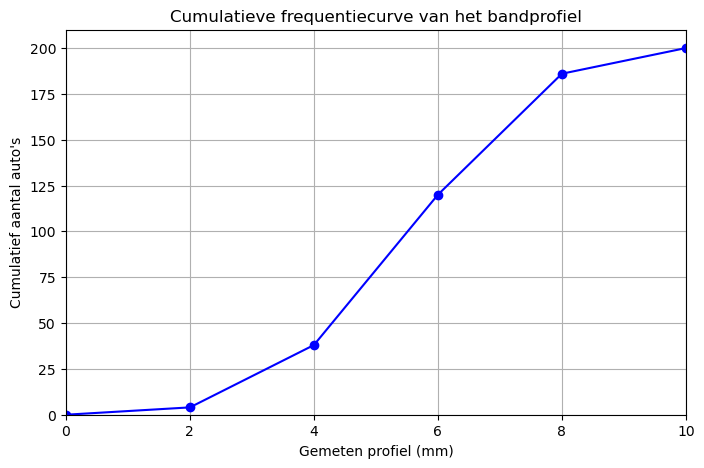

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Klassen en cumulatieve frequenties
klassen = [0, 2, 4, 6, 8, 10]
cumulatief = [0, 4, 38, 120, 186, 200]

# Teken de cumulatieve frequentiecurve
plt.figure(figsize=(8, 5))
plt.plot(klassen, cumulatief, marker='o', linestyle='-', color='blue')

# As-labels en titel
plt.xlabel('Gemeten profiel (mm)')
plt.ylabel('Cumulatief aantal auto\'s')
plt.title('Cumulatieve frequentiecurve van het bandprofiel')

# As-instellingen
plt.xlim(0, 10)
plt.ylim(0, 210)
plt.grid(True)

# Laat de grafiek zien
plt.show()


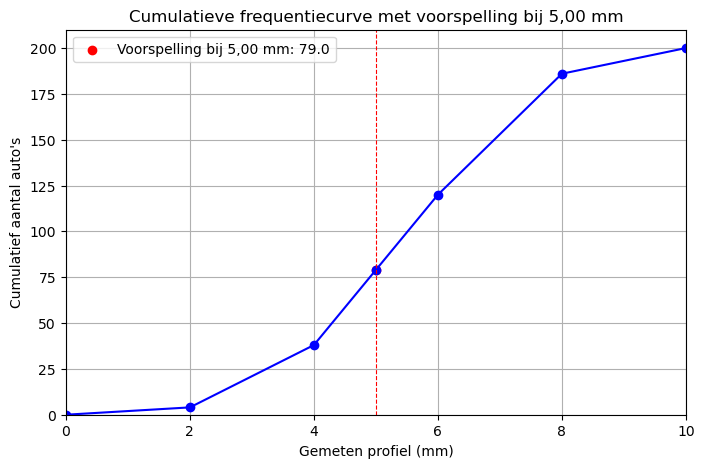

: 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Klassen en cumulatieve frequenties
klassen = [0, 2, 4, 6, 8, 10]
cumulatief = [0, 4, 38, 120, 186, 200]

# Interpolatie voor 5,00 mm
# Tussen 4,00 mm (38 auto's) en 6,00 mm (120 auto's)
x1, y1 = 4, 38
x2, y2 = 6, 120
x_voorspelling = 5
y_voorspelling = y1 + (y2 - y1) * (x_voorspelling - x1) / (x2 - x1)

# Voeg het voorspellingspunt toe
klassen_met_voorspelling = [0, 2, 4, 5, 6, 8, 10]
cumulatief_met_voorspelling = [0, 4, 38, y_voorspelling, 120, 186, 200]

# Teken de cumulatieve frequentiecurve
plt.figure(figsize=(8, 5))
plt.plot(klassen_met_voorspelling, cumulatief_met_voorspelling, marker='o', linestyle='-', color='blue')
plt.scatter(5, y_voorspelling, color='red', label=f'Voorspelling bij 5,00 mm: {y_voorspelling:.1f}')
plt.axvline(x=5, color='red', linestyle='--', linewidth=0.8)

# As-labels en titel
plt.xlabel('Gemeten profiel (mm)')
plt.ylabel('Cumulatief aantal auto\'s')
plt.title('Cumulatieve frequentiecurve met voorspelling bij 5,00 mm')
plt.legend()
plt.grid(True)

# As-instellingen
plt.xlim(0, 10)
plt.ylim(0, 210)

# Laat de grafiek zien
plt.show()


In [3]:
import numpy as np

# De oorspronkelijke scores
scores = [45, 60, 82, 32, 25, 75, 65, 66, 70, 80]

# (a) Bereken rekenkundig gemiddelde, mediaan en standaarddeviatie
mean = np.mean(scores)
median = np.median(scores)
std_dev = np.std(scores, ddof=1)

print("(a) Oorspronkelijke waarden:")
print(f"Gemiddelde: {mean}")
print(f"Mediaan: {median}")
print(f"Standaarddeviatie: {std_dev}")

# (b) Alle studenten krijgen 10 punten extra
adjusted_scores_add = [score + 10 for score in scores]
mean_add = np.mean(adjusted_scores_add)
median_add = np.median(adjusted_scores_add)
std_dev_add = np.std(adjusted_scores_add, ddof=1)

print("\n(b) Na 10 punten extra:")
print(f"Gemiddelde: {mean_add}")
print(f"Mediaan: {median_add}")
print(f"Standaarddeviatie: {std_dev_add}")

# (c) Alle scores worden met 10% verhoogd
adjusted_scores_mult = [score * 1.1 for score in scores]
mean_mult = np.mean(adjusted_scores_mult)
median_mult = np.median(adjusted_scores_mult)
std_dev_mult = np.std(adjusted_scores_mult, ddof=1)

print("\n(c) Na 10% hogere scores:")
print(f"Gemiddelde: {mean_mult}")
print(f"Mediaan: {median_mult}")
print(f"Standaarddeviatie: {std_dev_mult}")

(a) Oorspronkelijke waarden:
Gemiddelde: 60.0
Mediaan: 65.5
Standaarddeviatie: 19.73153144926499

(b) Na 10 punten extra:
Gemiddelde: 70.0
Mediaan: 75.5
Standaarddeviatie: 19.73153144926499

(c) Na 10% hogere scores:
Gemiddelde: 66.0
Mediaan: 72.05000000000001
Standaarddeviatie: 21.704684594191487


Students - Mean: 62.6333, Median: 56.0
Graduates - Mean: 125.95, Median: 99.0
Students - Standard Deviation: 29.9419
Graduates - Standard Deviation: 79.0949


C:\Users\danny\AppData\Local\Temp\ipykernel_22952\4137947837.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([students, graduates], labels=["Studenten", "Afgestudeerden"])


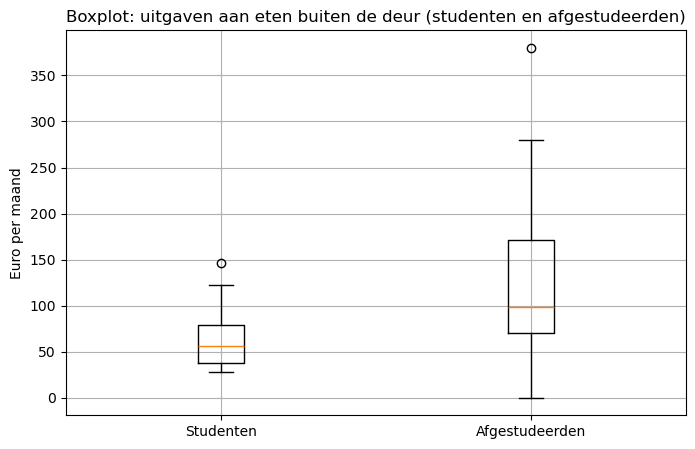

Q1: 37.75, Q3: 79.25, IQR: 41.5
Q1: 70.5, Q3: 171.0, IQR: 100.5
Students - Outliers: [146]
Graduates - Outliers: [380]


In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Data
students = [72, 51, 146, 30, 28, 88, 92, 47, 52, 68, 80, 34, 28, 105, 76, 93, 55, 40, 62, 37,
            88, 30, 122, 46, 35, 29, 77, 40, 71, 57]
graduates = [88, 130, 255, 56, 0, 38, 167, 188, 132, 147, 78, 80, 40, 170, 280, 46, 174, 182,
             75, 89, 103, 230, 380, 57, 55, 90, 96, 102, 78, 69, 53, 160, 195, 245, 60, 94,
             145, 115, 225, 71]

# (a) Mean and Median
mean_students = round(np.mean(students), 4)
median_students = round(np.median(students), 4)
mean_graduates = round(np.mean(graduates), 4)
median_graduates = round(np.median(graduates), 4)

print(f"Students - Mean: {mean_students}, Median: {median_students}")
print(f"Graduates - Mean: {mean_graduates}, Median: {median_graduates}")

# (b) Standard Deviation
std_students = round(np.std(students, ddof=1), 4)  # Population standard deviation
std_graduates = round(np.std(graduates, ddof=1), 4)

print(f"Students - Standard Deviation: {std_students}")
print(f"Graduates - Standard Deviation: {std_graduates}")

# (c) Boxplot and Outlier Detection
plt.figure(figsize=(8, 5))
plt.boxplot([students, graduates], labels=["Studenten", "Afgestudeerden"])
plt.title("Boxplot: uitgaven aan eten buiten de deur (studenten en afgestudeerden)")
plt.ylabel("Euro per maand")
plt.grid(True)
plt.show()

# Outlier detection using IQR
def detect_outliers(data):
    n = len(data)

    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3-Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = [x for x in data if x < lower_bound or x > upper_bound]

    print(f"Q1: {Q1}, Q3: {Q3}, IQR: {IQR}")
    return outliers

outliers_students = detect_outliers(sorted(students))
outliers_graduates = detect_outliers(sorted(graduates))

print(f"Students - Outliers: {outliers_students}")
print(f"Graduates - Outliers: {outliers_graduates}")

Gemiddelde studenten: 62.63333333333333
Mediaan studenten: 56.0
Gemiddelde afgestudeerden: 125.95
Mediaan afgestudeerden: 99.0
Standaarddeviatie studenten: 29.941878564212086
Standaarddeviatie afgestudeerden: 79.09486352410904
Custom Q1: 37.0, Custom Q3: 80.0, IQR: 43.0
Lower Bound: -27.5, Upper Bound: 144.5
Outliers: [146]


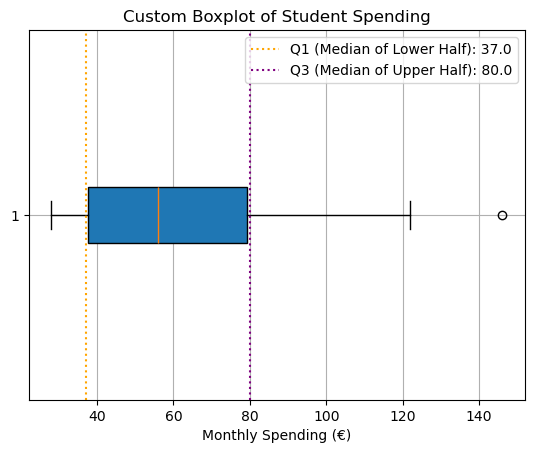

In [ ]:
import numpy as np

# Data
students = [72, 51, 146, 30, 28, 88, 92, 47, 52, 68, 80, 34, 28, 105, 76, 93, 55, 40, 62, 37,
            88, 30, 122, 46, 35, 29, 77, 40, 71, 57]
graduates = [88, 130, 255, 56, 0, 38, 167, 188, 132, 147, 78, 80, 40, 170, 280, 46, 174, 182,
             75, 89, 103, 230, 380, 57, 55, 90, 96, 102, 78, 69, 53, 160, 195, 245, 60, 94,
             145, 115, 225, 71]

# (a)

sorted_students = sorted(students)
n_students = len(sorted_students)
lower_median = sorted_students[n_students//2-1]
upper_median = sorted_students[n_students//2]
print(f"Gemiddelde studenten: {sum(sorted_students)/n_students}")
print(f"Mediaan studenten: {(lower_median+upper_median)/2}")

sorted_graduates = sorted(graduates)
n_graduates = len(sorted_graduates)
lower_median = sorted_graduates[n_graduates//2-1]
upper_median = sorted_graduates[n_graduates//2]
print(f"Gemiddelde afgestudeerden: {sum(sorted_graduates)/n_graduates}")
print(f"Mediaan afgestudeerden: {(lower_median+upper_median)/2}")

# (b)
variance_students = np.var(students, ddof=1)
std_students = np.sqrt(variance_students)
print(f"Standaarddeviatie studenten: {std_students}")

variance_graduates = np.var(graduates, ddof=1)
std_graduates = np.sqrt(variance_graduates)
print(f"Standaarddeviatie afgestudeerden: {std_graduates}")

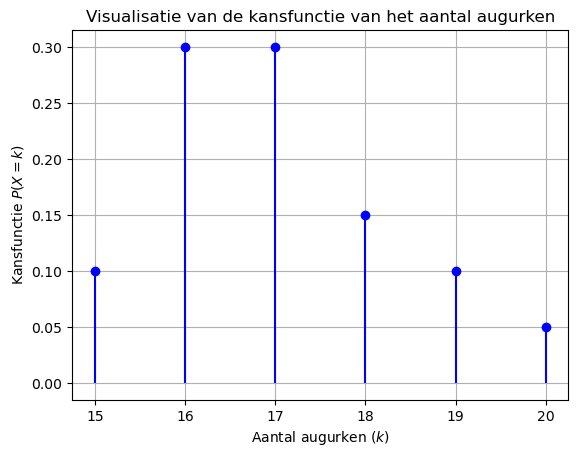

In [2]:
import matplotlib.pyplot as plt

# Data
k_values = [15, 16, 17, 18, 19, 20]
probabilities = [0.10, 0.30, 0.30, 0.15, 0.10, 0.05]

# Plot
plt.stem(k_values, probabilities, basefmt=" ", linefmt="b-", markerfmt="bo")
plt.title("Visualisatie van de kansfunctie van het aantal augurken")
plt.xlabel("Aantal augurken ($k$)")
plt.ylabel("Kansfunctie $P(X=k)$")
plt.grid(True)
plt.show()

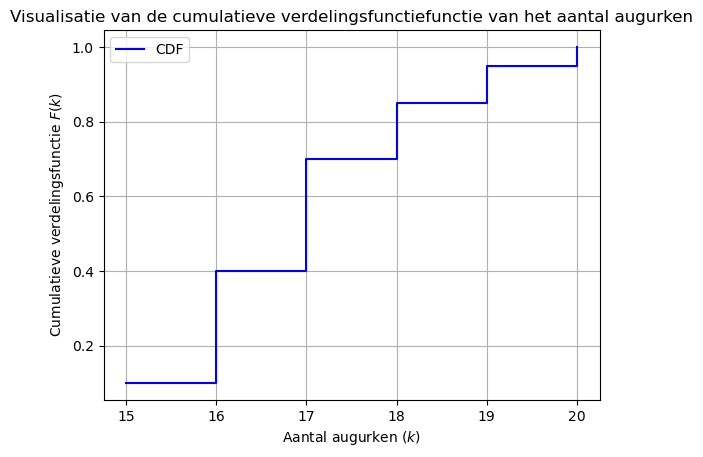

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Data
k_values = [15, 16, 17, 18, 19, 20]
probabilities = [0.10, 0.30, 0.30, 0.15, 0.10, 0.05]

# Berekening van de CDF
cdf = np.cumsum(probabilities)

# Plot
plt.step(k_values, cdf, where="post", color="b", label="CDF")
plt.title("Visualisatie van de cumulatieve verdelingsfunctiefunctie van het aantal augurken")
plt.xlabel("Aantal augurken ($k$)")
plt.ylabel("Cumulatieve verdelingsfunctie $F(k)$")
plt.grid(True)
plt.legend()
plt.show()

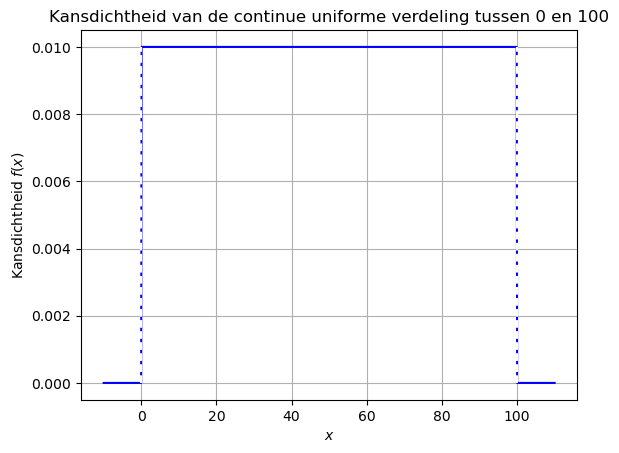

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define parameters
a, b = 0, 100  # Lower and upper bounds
x = np.linspace(-10, 110, 1000)  # Range for the x-axis
pdf = np.where((x >= a) & (x <= b), 1 / (b - a), 0)  # PDF with jumps at a and b

plt.plot(x, pdf, color="blue", label="Continuous Uniform Distribution")
plt.plot([a,a], [0, 1 / (b-a)], color="white", linestyle="--", label="Jump at a")
plt.plot([b,b], [0, 1 / (b-a)], color="white", linestyle="--", label="Jump at a")
plt.title(f"Kansdichtheid van de continue uniforme verdeling tussen {a} en {b}")
plt.xlabel("$x$")
plt.ylabel("Kansdichtheid $f(x)$")
plt.grid()
plt.show()

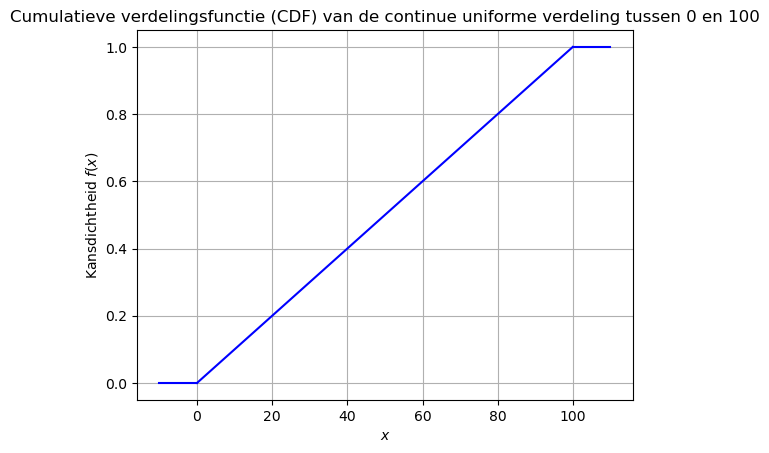

In [8]:
# import numpy as np
import matplotlib.pyplot as plt

# Define parameters
a, b = 0, 100  # Lower and upper bounds
x1 = np.linspace(-10, 0, 1000)  # Range for the x-axis
x2 = np.linspace(0, 100, 1000)  # Range for the x-axi
x3 = np.linspace(100, 110, 1000)  # Range for the x-axi

cdf1 = np.zeros(1_000)
cdf2 = (x2 - a) / (b - a)
cdf3 = np.ones(1_000)

plt.plot(x1, cdf1, color="blue", label="Continuous Uniform Distribution")
plt.plot(x2, cdf2, color="blue", label="Continuous Uniform Distribution")
plt.plot(x3, cdf3, color="blue", label="Continuous Uniform Distribution")
plt.title(f"Cumulatieve verdelingsfunctie (CDF) van de continue uniforme verdeling tussen {a} en {b}")
plt.xlabel("$x$")
plt.ylabel("Kansdichtheid $f(x)$")
plt.grid()
plt.show()

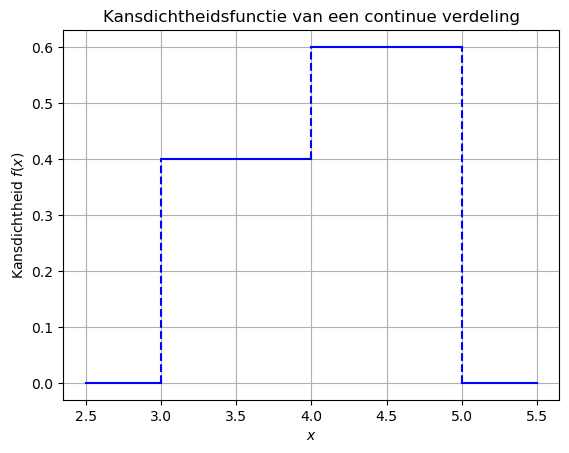

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Definieer het bereik
x1 = np.linspace(2.5, 3.0, 1000)
x2 = np.linspace(3.0, 4.0, 1000)
x3 = np.linspace(4.0, 5.0, 1000)
x4 = np.linspace(5.0, 5.5, 1000)

f1 = np.array([0 for _ in x1])
f2 = np.array([0.4 for _ in x2])
f3 = np.array([0.6 for _ in x3])
f4 = np.array([0 for _ in x4])

# Plot
plt.plot(x1, f1, color='blue', label='Kansdichtheid f(x)')
plt.plot(x2, f2, color='blue', label='Kansdichtheid f(x)')
plt.plot(x3, f3, color='blue', label='Kansdichtheid f(x)')
plt.plot(x4, f4, color='blue', label='Kansdichtheid f(x)')

plt.plot([3.0, 3.0], [0.0, 0.4], color='blue', linestyle='--', label='Sprong bij x = 3.0')
plt.plot([4.0, 4.0], [0.4, 0.6], color='blue', linestyle='--', label='Sprong bij x = 4.0')
plt.plot([5.0, 5.0], [0.0, 0.6], color='blue', linestyle='--', label='Sprong bij x = 5.0')

# Opmaak
plt.title("Kansdichtheidsfunctie van een continue verdeling")
plt.xlabel("$x$")
plt.ylabel("Kansdichtheid $f(x)$")
plt.grid()
plt.show()

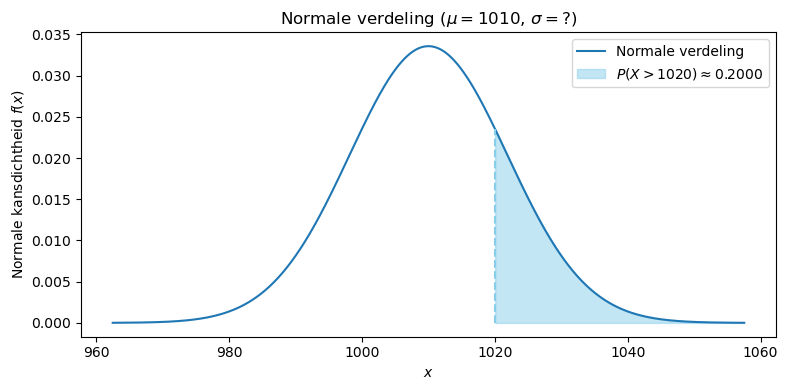

In [63]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# Parameters
mu = 1010
sigma = 11.8818295  # Aangenomen waarde voor illustratie; de gebruiker zei "onbekend"
x = np.linspace(mu - 4*sigma, mu + 4*sigma, 1000)
y = norm.pdf(x, mu, sigma)

# Kansberekening
x_val = 1020
prob = 1 - norm.cdf(x_val, mu, sigma)

# Plot
plt.figure(figsize=(8, 4))
plt.plot(x, y, label='Normale verdeling')
plt.fill_between(x, y, where=(x >= x_val), color='skyblue', alpha=0.5, label=f'$P(X > 1020) \\approx {prob:.4f}$')
plt.plot([x_val, x_val], [0, norm.pdf(x_val, mu, sigma)], color='skyblue', linestyle='--')
plt.title(f'Normale verdeling ($\\mu={mu}$, $\\sigma=?$)')
plt.xlabel('$x$')
plt.ylabel('Normale kansdichtheid $f(x)$')
plt.legend()
# plt.grid(True)
plt.tight_layout()
# plt.show()
plt.savefig("opg5.2a.png")


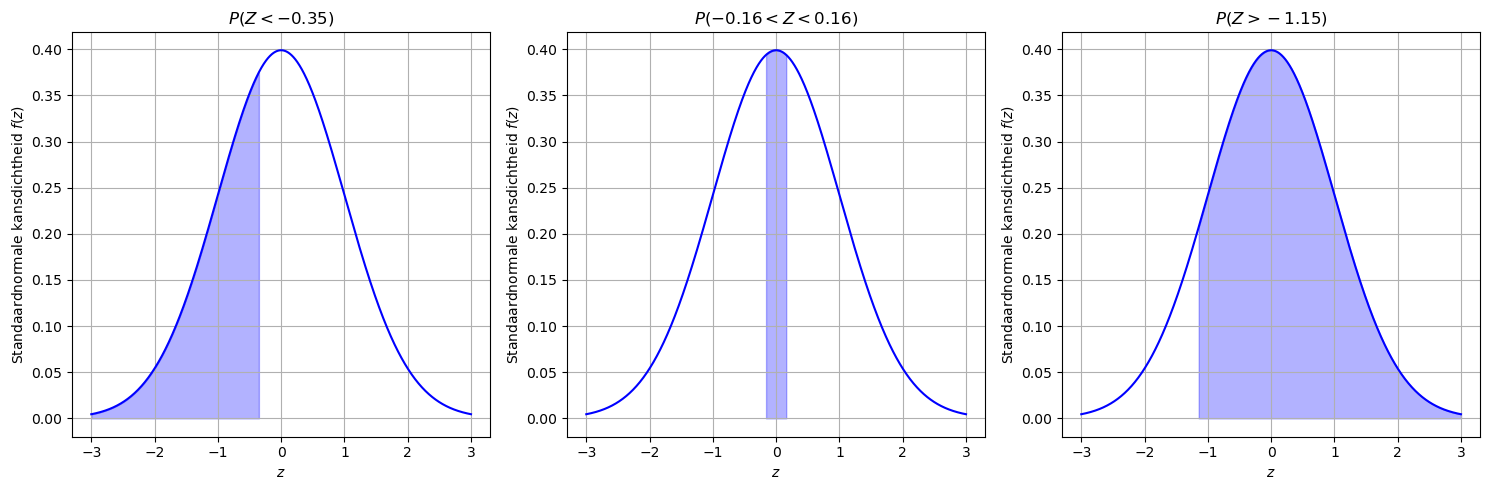

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Definieer de Z-waarden voor de kansen
z_values = [(-np.inf, -0.35), (-0.16, 0.16), (-1.15, np.inf)]
titles = [r"$P(Z < -0.35)$", r"$P(-0.16 < Z < 0.16)$", r"$P(Z > -1.15)$"]

# Genereer de standaardnormale verdeling
x = np.linspace(-3, 3, 1000)
y = stats.norm.pdf(x, 0, 1)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, (z_min, z_max), title in zip(axes, z_values, titles):
    ax.plot(x, y, color="blue")  # Kansdichtheidsfunctie
    
    # Invullen van het gebied onder de curve
    mask = (x >= z_min) & (x <= z_max)
    ax.fill_between(x[mask], y[mask], color="blue", alpha=0.3)

    ax.set_title(title)
    ax.set_xlabel("$z$")
    ax.set_ylabel("Standaardnormale kansdichtheid $f(z)$")
    ax.grid(True)

plt.tight_layout()
plt.show()

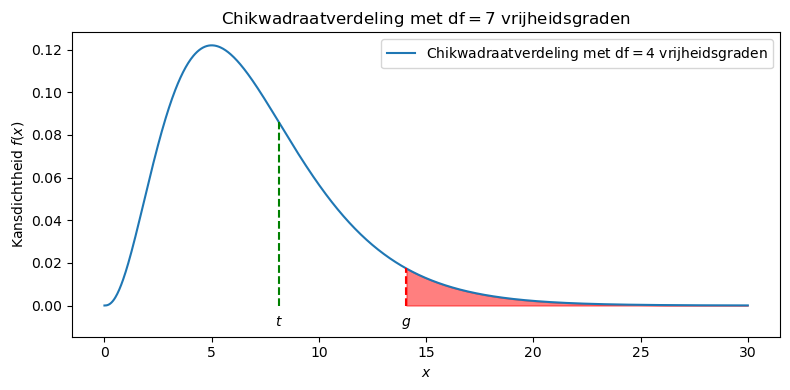

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chi2

# Parameters
df=7
x = np.linspace(0, 30, 1000)
y = chi2.pdf(x, df=df)
maxy = max(y)

# Kansberekening
t = 8.1304
x_val = chi2.ppf(0.95, df=df)
# prob = 1 - chi2.cdf(x_val, df=df)

# Plot
plt.figure(figsize=(8, 4))
plt.plot(x, y, label='Chikwadraatverdeling met df$=4$ vrijheidsgraden')
plt.fill_between(x, y, where=(x >= x_val), color='red', alpha=0.5)
plt.plot([t, t], [0, chi2.pdf(t, df=df)], color='green', linestyle='--')
plt.plot([x_val, x_val], [0, chi2.pdf(x_val, df=df)], color='red', linestyle='--')

plt.text(t, -0.08 * maxy, "$t$", ha="center")
plt.text(x_val, -0.08 * maxy, "$g$",  ha="center")
plt.title(f'Chikwadraatverdeling met df$={df}$ vrijheidsgraden')
plt.xlabel('$x$')
plt.ylabel('Kansdichtheid $f(x)$')
plt.legend()
plt.ylim(bottom=-0.12 * maxy)
# plt.grid(True)
plt.tight_layout()
plt.show()

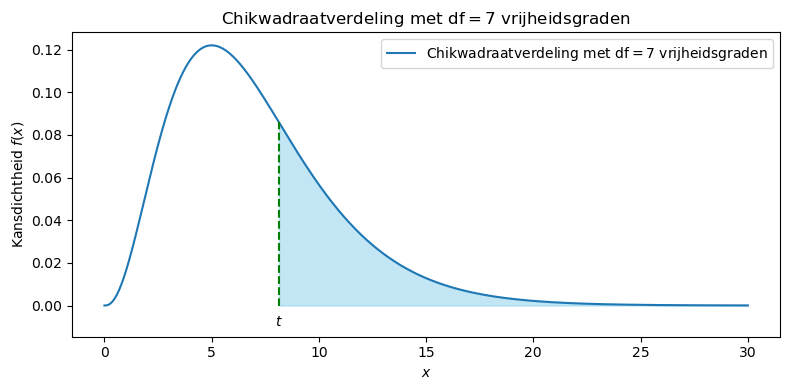

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chi2

# Parameters
df = 7
x = np.linspace(0, 30, 1000)
y = chi2.pdf(x, df=df)
maxy = max(y)

# Kansberekening
t = 8.1304
prob = 1 - chi2.cdf(x_val, df=df)

# Plot
plt.figure(figsize=(8, 4))
plt.plot(x, y, label=f'Chikwadraatverdeling met df$={df}$ vrijheidsgraden')
plt.fill_between(x, y, where=(x >= t), color='skyblue', alpha=0.5)
plt.plot([t, t], [0, chi2.pdf(t, df=df)], color='green', linestyle='--')

plt.text(t, -0.08 * maxy, "$t$", ha="center")
plt.title(f'Chikwadraatverdeling met df$={df}$ vrijheidsgraden')
plt.xlabel('$x$')
plt.ylabel('Kansdichtheid $f(x)$')
plt.legend()
plt.ylim(bottom=-0.12 * maxy)
# plt.grid(True)
plt.tight_layout()
plt.show()